In [1]:
import sys
import numpy as np
from matplotlib import pyplot as plt
sys.path.append('..')
from scipy.constants import hbar, e, h
from IPython.display import Image 
%config InlineBackend.figure_format='retina'

# Single transmon qubit

Calculations for weakly anharmonic systems can be divide into two main parts:
1. Calculations for linear circuit, where all nonlinaer elements are replaced by linear inductances

2. Calculation of Kerr matrix, which defines anharmonicities and dispersive shifts

## Create linear circuit

In [2]:
from tlsim2.lumped import LumpedTwoTerminal
from tlsim2.lumped import JosephsonJunction

Cq = 123e-15
EJ = 36e9 * h

EC = e ** 2 / Cq / 2

ratio = EJ / EC

print(f"Transmon ratio is {ratio}")

# qubit capacitor
capacitor_qubit = LumpedTwoTerminal(name='Cq', c=Cq)

# qubit nonlinear element
jj1 =  JosephsonJunction(name='JJ1', ej=1 * EJ / 6)
jj2 =  JosephsonJunction(name='JJ2', ej=5 * EJ / 6)

from tlsim2.circuit import Circuit

linear_circuit = Circuit()
linear_circuit.add_element(capacitor_qubit, {'i': 0, 'o': 1})

linear_circuit.add_element(jj1, {'i': 0, 'o': 1})
linear_circuit.add_element(jj2, {'i': 0, 'o': 1})
linear_circuit.short(0)

w, v, node_names = linear_circuit.compute_system_modes(only_positive=True)
frequencies, decays  =  w.imag / 2 / np.pi, w.real / 2 / np.pi
frequencies, decays 

Transmon ratio is 228.59822285960075


(array([6.73458858e+09]), array([0.]))

## Create nonlinear circuit

In [3]:
print(linear_circuit.nonlinear_elements)

from tlsim2.quantum_circuit import QuantumCircuit
nonlinear_circuit = QuantumCircuit(linear_circuit)

print(f"Number of modes in the system is {nonlinear_circuit.num_modes} and \
number of nonlinaer elements is {nonlinear_circuit.num_nonlinear_elements}")

OrderedDict([('JJ1', <tlsim2.lumped.JosephsonJunction object at 0x000002B7D7BA01F0>), ('JJ2', <tlsim2.lumped.JosephsonJunction object at 0x000002B7B76C1610>)])
Number of modes in the system is 1 and number of nonlinaer elements is 2


Calculate EPR matrix $\bf{p}$ which is defined as $p_{mj} =  \frac{\text{Inductive energy in junction }j}{\text{Half of total energy if the mode } m}$ (https://www.nature.com/articles/s41534-021-00461-8)

In [4]:
nonlinear_circuit.get_epr_coefficients(), np.sum(nonlinear_circuit.get_epr_coefficients())

(array([[0.16666667, 0.83333333]]), 0.9999999999999998)

Kerr matrix and ahharmonicities for order $d=4$ of nonlinerity can be calculated using the approach presented in the paper
https://www.nature.com/articles/s41534-021-00461-8
$$\mathbf{\chi} = \frac{\hbar}{2} \Omega P E_J ^ {-1} P \Omega,$$ where

$\Omega$ is a diagonal matrix with frequencies of normal modes

$E_J$ is a diagonal matrix with Josephson energies of non-linear elements

$P$ is a matrix of energy participation ratios  

In [5]:
kerr_matrix, anharmonicities = nonlinear_circuit.get_kerr_matrix()
kerr_matrix / (2 * np.pi), anharmonicities / (2 * np.pi)

f_p = frequencies[0]
alpha = - anharmonicities[0] / (2 * np.pi) / 1e6

print(f"Plasma frequency for transmon qubit is {f_p /1e9 :.2f} GHz and \
anharmonicity {alpha :.2f} MHz, therefore qubit transition is {(f_p + alpha * 1e6) / 1e9 :.3f} GHz")

Plasma frequency for transmon qubit is 6.73 GHz and anharmonicity -157.48 MHz, therefore qubit transition is 6.577 GHz


## Calculate spectrum using basis of harmonic modes

Alternatively, energy spectrum of the system can be calculated in the basis of harmonic modes 
$$H = H_{lin} + \sum_{j=1} ^ J \left(\sum_{p=3} ^ {p_{\text{max}}} \frac{\varphi_0 ^ p}{p L_p} \hat{\varphi}_j \right),$$
where 

$H_{lin} = \sum_m \hbar a ^ {\dagger}_m a_m$ is a linear part of Hamiltonian,

$J$ is a number of non-linear elements in the system,

$p_{\text{max}}$ is a maximum order of expansion

In [6]:
ham = nonlinear_circuit.get_hamiltonian_perturbation(modes=[0], num_levels=[7], order=4)

import scipy
energies, states = np.linalg.eigh(ham)
transitions = (energies - energies[0]) / hbar / 2 / np.pi
transitions

array([0.00000000e+00, 6.56895782e+09, 1.29627408e+10, 1.91808450e+10,
       2.53181582e+10, 3.19515260e+10, 3.96647127e+10])

Using this Hamiltonian one can calculate self-Kerr and cross-Kerr coefficients as matrix elements of single-photon and double photon states in the dispersive limit.

For single photon states $|m \rangle$: $\langle m|H|m \rangle = \hbar \omega_m + A_m$, where states $|m \rangle = |0...1...0 \rangle $ with one ptohon in mode $m$

For double photon states $|m n \rangle$: $\langle mn|H|mn \rangle = \hbar \omega_m + A_m + \hbar \omega_n + A_n$, where states $|nm \rangle = |0...1...1...0 \rangle $ with one ptohon in mode $m$ and one ptohon in mode $n$

In [7]:
omegas = nonlinear_circuit.circuit.w[2:].imag
energies, kerr = nonlinear_circuit.get_kerr_matrix_hamiltonian(modes=[0], num_levels=[6])
kerr / hbar / 2 / np.pi 

array([[-1.57481539e+08+0.j]])

## External flux in SQUID

According to the second Kirchhoff's law for each loop $\ell$ presented in a circuit
$$\sum_{i \in \ell} \Delta \Phi_i = \Phi_{\text{ext}},$$
where $\Delta \Phi_i$ is flux difference across element $i$ in a loop.
Using this approach we can find stationary phases on each two-port element in a circuit.
For example, for a SQUID element formed by two Josepshon junctions $E_{J1}$ and $E_{J2}$. For this loop with two physical nodes 1 and 0 (grounded node) one can add a strationary node 2 nd rewrite the second Kirchhoff's law
$$ \Delta \phi_{J1} + \Delta \phi_{J2} = 0 - \phi_1 + \phi_1 - \phi_2 = \phi_{\text{ext}}$$
This eqution defines a constraint for generalized coordinates $\Phi_1$ and $\Phi_2$ which can be used for potential enrgy minimization of the circuit
$$U(\phi_1, \phi_2) = E_{J1} (1 - \cos (\phi_1))  + E_{J2} (1 - \cos (\phi_1 - \phi_2)) \rightarrow \text{min} (\phi_1, \phi_2)$$

The necessity of an additional stationary node is equivalent to the presence of a voltage source in the loop.

In [8]:
Image(url="pictures/SQUID.png", width=400, height=400) 

The first step is to define a loop as a set of elements as follows

In [9]:
from tlsim2.circuit_stationary_phases import CircuitStationaryPhases

circuit_stationary_phases = CircuitStationaryPhases(linear_circuit)
circuit_stationary_phases.add_circuit_loop(loop_name='SQUID_loop', loop=[jj1, jj2])
circuit_stationary_phases.setup_stationary_phases()

Stationary node stationary_node_SQUID_loop for loop SQUID_loop was added to the circuit None


After definition of all loops, ona can calculate and set sttaionary phases to a circuit elements

Text(0, 0.5, 'frequency (GHz)')

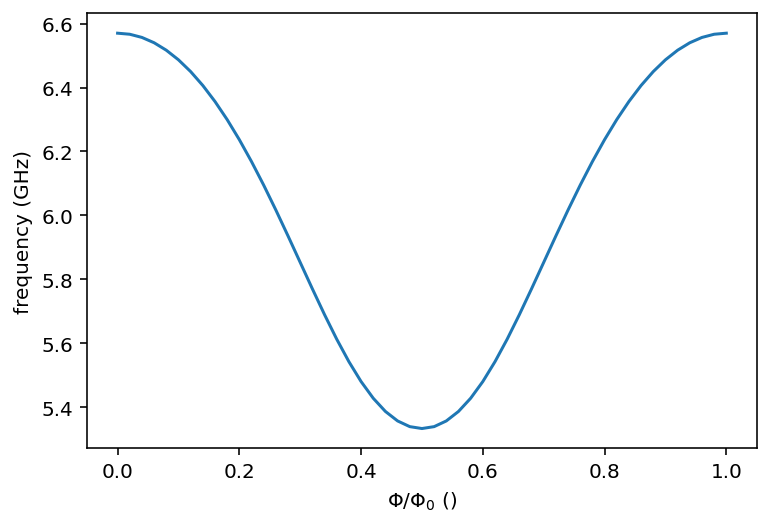

In [10]:
phi_ext =  np.linspace(0., 2 * np.pi, 51)

frequencies01 = np.zeros(len(phi_ext))
for i, flux in enumerate(phi_ext):
    circuit_stationary_phases.reset_phases()
    circuit_stationary_phases.circuit_loops['SQUID_loop'].flux = flux
    stationary_phases = circuit_stationary_phases.get_stationary_phases()
    circuit_stationary_phases.set_stationary_phases(stationary_phases, report=False)
    linear_circuit.compute_system_modes(only_positive=True)
    ham = nonlinear_circuit.get_hamiltonian_perturbation(modes=[0], num_levels=[5], order=4)
    energies, states = np.linalg.eigh(ham)
    transitions = (energies - energies[0]) / hbar / 2 / np.pi
    frequencies01[i] =  transitions[1]
    

plt.plot(phi_ext / np.pi / 2, frequencies01 / 1e9)
plt.xlabel("$\Phi / \Phi_0$ ()")
plt.ylabel("frequency (GHz)")

## Compare result with theory

Plasma frequency of transmon qubit is defined as $\omega_{p} =  \sqrt{8 E_C E_J}$,

anharmonicity for transmon qubit is $\alpha = -E_C$

and transition $\omega_{01} =  \omega_p + \alpha$ 

In [11]:
EC = e ** 2 / Cq / 2 
f_p = np.sqrt(8 * EC * EJ / h / h)

print(f"Plasma frequency for transmon qubit is {f_p / 1e9 :.2f} GHz and anharmonicity {- EC / h / 1e6 :.2f} MHz")

Plasma frequency for transmon qubit is 6.73 GHz and anharmonicity -157.48 MHz


Energy levels of transmon are calculated using the following equation
$$E_m = \sqrt{8 E_C E_J} (m + \frac{1}{2}) - \frac{E_C}{12}(6 m ^ 2 + 6 m + 3) $$

In [12]:
EC = e ** 2 / Cq / 2
def transmon_levels(m, EC, EJ):
    return np.sqrt(8 * EC * EJ) * (m + 1 / 2) - EC / 12 * (6 * m ** 2 + 6 * m + 3)

energies =  np.asarray([transmon_levels(m, EC, EJ) / hbar / 2 / np.pi for m in range(5)])
transitions = energies - energies[0]
anharmonicity = (transitions[2] - transitions[1]) - ( transitions[1] - transitions[0])
transitions, anharmonicity / 1e6

(array([0.00000000e+00, 6.57710704e+09, 1.29967325e+10, 1.92588765e+10,
        2.53635389e+10]),
 -157.4815392248745)

For SDUID one can use the foloowing equation
$$E_{J, \text{eff}} =  E_{J, \Sigma} \sqrt{\cos ^ 2 \left(\pi \frac{\Phi}{\Phi_0} \right) + d ^ 2\sin ^ 2 \left(\pi \frac{\Phi}{\Phi_0} \right)},$$
where $E_{J, \Sigma}= E_{J1} + E_{J2}$ and $d= \frac{E_{J1} - E_{J2}} {E_{J1} + E_{J2}}$

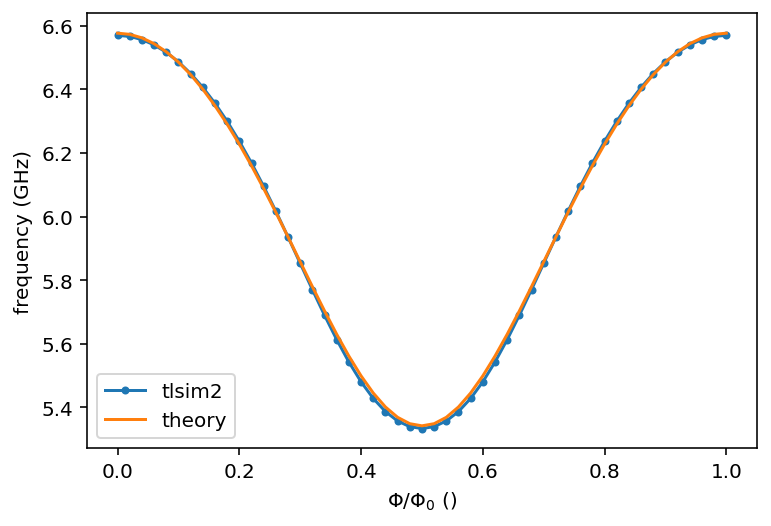

In [13]:
def ej_SQUID(ej1, ej2):
    d = (ej2 - ej1) / (ej2 + ej1)
    e_sum = ej1 + ej2
    return lambda x: e_sum * np.sqrt(np.cos(x / 2) ** 2 + d ** 2 * np.sin(x / 2)**2)

frequencies01_theory = np.zeros(len(phi_ext))
for i, flux in enumerate(phi_ext):
    EJ_eff = ej_SQUID(1 * EJ / 6, 5 * EJ / 6)(flux)
    energies =  np.asarray([transmon_levels(m, EC, EJ_eff) / hbar / 2 / np.pi for m in range(2)])
    transitions = energies - energies[0]
    frequencies01_theory[i] = transitions[1]
    
plt.plot(phi_ext / 2 / np.pi, frequencies01 / 1e9, label='tlsim2', marker='.')
plt.plot(phi_ext / 2 / np.pi, frequencies01_theory / 1e9, label='theory')
plt.xlabel("$\Phi / \Phi_0$ ()")
plt.ylabel("frequency (GHz)")
plt.legend()

# Circuit of coupled qubit and resonator

## Linear approximation

In [14]:
from tlsim2.lumped import LumpedTwoTerminal
from tlsim2.lumped import JosephsonJunction

Cr = 166.448e-12 * 4e-3 / 2
Lr = 1 / Cr / (2 * np.pi * 7.9e9) ** 2
CJ = 73e-15
EJ = 17e9 * h
Cc = 10e-15

print(f"Transmon ratio is {EJ / (e ** 2 / 2 / CJ)}")

# resonator transmission line
capacitor_res = LumpedTwoTerminal(name='Cr', c=Cr)
inductor_res = LumpedTwoTerminal(name='Lr', l=Lr)

# qubit capacitor
capacitor_qubit = LumpedTwoTerminal(name='CJ', c=CJ)

# qubit nonlinear element
jj = JosephsonJunction(name='JJ', ej=EJ)

# coupling capacitor
capacitor_coupl = LumpedTwoTerminal(name='Cc', c=Cc)


from tlsim2.circuit import Circuit

linear_circuit = Circuit()
linear_circuit.add_element(capacitor_qubit, {'i': 0, 'o': 1})
linear_circuit.add_element(jj, {'i': 0, 'o': 1})
linear_circuit.add_element(capacitor_res, {'i': 2, 'o': 0})
linear_circuit.add_element(inductor_res, {'i': 2, 'o': 0})
linear_circuit.add_element(capacitor_coupl, {'i': 1, 'o': 2})
linear_circuit.short(0)

w, v, node_names = linear_circuit.compute_system_modes(only_positive=True)
w = w / 2 / np.pi
frequencies, decays  =  w.imag, w.real
frequencies, decays 

Transmon ratio is 64.0673881139938


(array([5.62298233e+09, 7.81259956e+09]), array([0., 0.]))

## Nonlinear circuit

In [15]:
from tlsim2.quantum_circuit import QuantumCircuit
nonlinear_circuit = QuantumCircuit(linear_circuit)

print(f"Number of modes in the system is {nonlinear_circuit.num_modes} and \
number of nonlinear elements is {nonlinear_circuit.num_nonlinear_elements}")

kerr_matrix, anharmonicities = nonlinear_circuit.get_kerr_matrix()
kerr_matrix / (2 * np.pi), anharmonicities / (2 * np.pi)

Number of modes in the system is 2 and number of nonlinear elements is 1


(array([[-4.57628667e+08, -5.07945027e+06],
        [-5.07945027e+06, -5.63793681e+04]]),
 array([-2.28814333e+08, -2.81896841e+04]))

In [16]:
ham = nonlinear_circuit.get_hamiltonian_perturbation(modes=[0, 1], num_levels=[4, 7], order=4)
energies, states = np.linalg.eigh(ham)
transitions = (energies - energies[0]) / hbar / 2 / np.pi
transitions

array([0.00000000e+00, 5.38639111e+09, 7.81008035e+09, 1.07859021e+10,
       1.31924425e+10, 1.56201398e+10, 1.66449251e+10, 1.85862136e+10,
       2.09984810e+10, 2.34301785e+10, 2.44481174e+10, 2.63865360e+10,
       2.88045064e+10, 3.12401967e+10, 3.22512181e+10, 3.41868702e+10,
       3.66105200e+10, 3.90503221e+10, 4.00542264e+10, 4.19872224e+10,
       4.44168626e+10, 4.68703655e+10, 4.78571511e+10, 4.97885069e+10,
       5.22552263e+10, 5.56612441e+10, 5.76490573e+10, 6.35066997e+10])

In [17]:
energies, kerr = nonlinear_circuit.get_kerr_matrix_hamiltonian(modes=[0, 1], num_levels=[7, 7])
kerr / hbar / 2 / np.pi 

(array([[-5.10231954e+08+0.j, -4.12499402e+06+0.j],
        [-4.12499402e+06+0.j, -3.84777879e+04+0.j]]),
 array([-2.55115977e+08+0.j, -1.92388939e+04+0.j]))

## Comparison with theory

From Koch article the dispersive shift in MHz is calculated by the equation 
$$\hbar \chi = - (\beta e V_{\text{rms}}) ^ 2 \sqrt{\frac{E_J}{2 E_C}}  \frac{E_C}{\hbar \Delta_0 (\hbar \Delta_0 - E_C)}$$
in the limit when $EC / EJ << 1$

In [18]:
v_rms0 = np.sqrt(hbar * 2 * np.pi * frequencies[1] / 2 / Cr)
beta = Cc / (CJ + Cc) 
EC = e ** 2 / (CJ + Cc) / 2
Delta0 = hbar * 2 * np.pi * frequencies[1] - (hbar * 2 * np.pi * frequencies[0] - EC)

chi = -(beta * e * v_rms0) ** 2 * np.sqrt(EJ / EC / 2) * EC / (Delta0 * (Delta0 - EC)) / hbar
chi / 2 / np.pi / 1e6

-1.751793518227923

# Circuit of coupled transmon qubit and $\lambda / 4$ resonator

In [19]:
from tlsim2.tl import MultiTransmissionLine
from tlsim2.tl import default_tl_basis

from tlsim2.lumped import LumpedTwoTerminal
from tlsim2.lumped import JosephsonJunction

from tlsim2.circuit import Circuit

ll = [[416.120e-9]]  # per-unit-length inductance for a 50-ohm TL on cold silicon
cl = [[166.448e-12]]  # per-unit-length capacitance for a 50-ohm TL on cold silicon

vp = 1/np.sqrt(np.asarray(cl)*np.asarray(ll))
length = 4e-3

CJ = 73e-15
EJ = 16e9 * h
Cc = 4e-15

## Make an element from TL resonator with frequency cutoff

In [20]:
# resonator transmission line
default_basis1 = default_tl_basis(1, n_harmonics=1)
tl = MultiTransmissionLine('TL', n=1, l=length, ll=ll,
                           cl=cl, basis=default_basis1)

tl_circuit = Circuit()
tl_circuit.add_element(tl, {'i0': 2, 'o0': 0})
tl_circuit.short(0)

w, v, node_names = tl_circuit.compute_system_modes(only_positive=True)
w = w / 2 / np.pi
frequencies, decays  =  w.imag, w.real
frequencies, decays 

(array([4.92951317e+10, 2.30217994e+10, 7.50985293e+09]), array([0., 0., 0.]))

In [21]:
cutoff_high = 8e9*(2*np.pi)
resonator = tl_circuit.make_element({2: 'res_open'}, cutoff_low = 0, cutoff_high = cutoff_high)

## In linear approximation

In [22]:
# qubit capacitor
capacitor_qubit = LumpedTwoTerminal(name='CJ', c=CJ)

# qubit nonlinear element
jj = JosephsonJunction(name='JJ', ej=EJ)

# coupling capacitor
capacitor_coupl = LumpedTwoTerminal(name='Cc', c=Cc)

In [23]:
from tlsim2.circuit import Circuit

linear_circuit = Circuit()
linear_circuit.add_element(capacitor_qubit, {'i': 0, 'o': 1})
linear_circuit.add_element(jj, {'i': 0, 'o': 1})
linear_circuit.add_element(resonator, {'res_open': 2})
linear_circuit.add_element(capacitor_coupl, {'i': 1, 'o': 2})
linear_circuit.short(0)

w, v, node_names = linear_circuit.compute_system_modes(only_positive=True)
w = w / 2 / np.pi
frequencies, decays  =  w.imag, w.real
frequencies, decays 

(array([2.93587488e+10, 5.67185111e+09, 7.47048382e+09]), array([0., 0., 0.]))

## Nonlinear circuit

Check all nonlinear elements in the circuit

In [24]:
linear_circuit.nonlinear_elements

OrderedDict([('JJ', <tlsim2.lumped.JosephsonJunction at 0x2b7d7d6d0d0>)])

Now one can create quantum nonlinear circuit from this linear circuit

In [25]:
from tlsim2.quantum_circuit import QuantumCircuit
nonlinear_circuit = QuantumCircuit(linear_circuit)

print(f"Number of modes in the system is {nonlinear_circuit.num_modes} and \
number of nonlinear elements is {nonlinear_circuit.num_nonlinear_elements}")

Number of modes in the system is 3 and number of nonlinear elements is 1


In [26]:
 nonlinear_circuit.get_epr_coefficients(), np.sum(nonlinear_circuit.get_epr_coefficients())

(array([[8.77178015e-05],
        [9.97914455e-01],
        [1.99782676e-03]]),
 0.9999999999999988)

Kerr matrix defines the Hamiltonian function in the following form
$$H = \sum_{m} \hbar \omega_m a_m ^ {\dagger} a_m + \frac{1}{2} \sum_{n, m} \chi_{m n} a_m ^ {\dagger} a_m a_n ^ {\dagger} a_n$$
From this approach anharmonicity of mode $m$ is calculated as $A_m =  \frac{1}{2} \chi_{mm}$

In [27]:
kerr_matrix, anharmonicities = nonlinear_circuit.get_kerr_matrix()
kerr_matrix / (2 * np.pi), anharmonicities / (2 * np.pi)

(array([[1.03626442e+02, 2.27752652e+05, 6.00553720e+02],
        [2.27752652e+05, 5.00560178e+08, 1.31991121e+06],
        [6.00553720e+02, 1.31991121e+06, 3.48043186e+03]]),
 array([5.18132211e+01, 2.50280089e+08, 1.74021593e+03]))

In [28]:
ham = nonlinear_circuit.get_hamiltonian_perturbation(modes=[1, 2], num_levels=[4, 7], order=4)

import scipy
energies, _ = np.linalg.eigh(ham)
transitions = (energies - energies[0]) / hbar / 2 / np.pi
transitions

array([0.00000000e+00, 5.41531343e+09, 7.46985112e+09, 1.08468721e+10,
       1.28842202e+10, 1.49397011e+10, 1.67750261e+10, 1.83142556e+10,
       2.03531264e+10, 2.24095500e+10, 2.42428798e+10, 2.57816415e+10,
       2.78220319e+10, 2.98793977e+10, 3.17107260e+10, 3.32490297e+10,
       3.52909368e+10, 3.73492524e+10, 3.91785646e+10, 4.07164204e+10,
       4.27598656e+10, 4.48216714e+10, 4.66463959e+10, 4.81838890e+10,
       5.02373925e+10, 5.41143410e+10, 5.56680709e+10, 6.15946354e+10])

In [29]:
energies, kerr = nonlinear_circuit.get_kerr_matrix_hamiltonian(modes=[1, 2], num_levels=[7, 7])
kerr / hbar / 2 / np.pi, energies / hbar / 2 / np.pi

(array([[-2.50940045e+08+0.j, -1.31991121e+06+0.j],
        [-1.31991121e+06+0.j, -6.61695819e+05+0.j]]),
 array([5.42091106e+09+0.j, 7.46982213e+09+0.j]))